## Combining of  SAKT with Riiid LGBM bagging2 then remove some features

Source Kernels
* SAKT + Riiid LGBM bagging2 LB 0.780 [https://www.kaggle.com/leadbest/sakt-riiid-lgbm-bagging2](http://)
* SAKT with Randomization & State Updates LB0.771 https://www.kaggle.com/leadbest/sakt-with-randomization-state-updates
* Riiid! LGBM bagging2 LB0.772 https://www.kaggle.com/zephyrwang666/riiid-lgbm-bagging2

In [1]:
import numpy as np
import pandas as pd
import psutil

from collections import defaultdict
import lightgbm as lgb
from matplotlib import pyplot as plt
import random
from sklearn.metrics import roc_auc_score
import gc 

_ = np.seterr(divide='ignore', invalid='ignore')

# Preprocess

In [2]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
    }
target = 'answered_correctly'

In [3]:
train_df = pd.read_csv('/data/elastic-notebook/data/riiid-test-answer-prediction/train.csv')

In [4]:
print(train_df.dtypes)

row_id                              int64
timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                     int64
task_container_id                   int64
user_answer                         int64
answered_correctly                  int64
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object


In [5]:
print(psutil.virtual_memory().percent)

14.6


In [6]:
#reading in lecture df
lectures_df = pd.read_csv('/data/elastic-notebook/data/riiid-test-answer-prediction/lectures.csv')

In [7]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [8]:
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [9]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

In [10]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
    }
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

In [11]:
for column in user_lecture_stats_part.columns:
    #bool_column = column + '_boolean'
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [12]:
train_lectures[train_lectures.user_id==5382]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
1,117,10183847,5382,16736,1,21,-1,-1,NaN,False,...,0,0,0,0,0,0,1,0,0,0
2,212,1424348597,5382,30207,1,104,-1,-1,NaN,False,...,0,0,0,1,0,0,1,0,0,0
3,216,1425557777,5382,18545,1,121,-1,-1,NaN,False,...,0,0,0,1,0,0,1,0,0,0


In [13]:
user_lecture_stats_part[user_lecture_stats_part.user_id==5382]

,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
1,5382,1,0,0,0,1,0,0,1,0,0,0


In [14]:
user_lecture_stats_part.tail()

,user_id,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
149601,2147419988,1,0,1,0,1,1,0,1,0,1,0
149602,2147469944,1,0,0,1,1,0,0,1,0,0,0
149603,2147470770,0,0,0,0,1,0,0,1,0,0,0
149604,2147470777,0,0,0,1,1,0,0,1,0,0,0
149605,2147482216,0,1,0,0,0,0,0,1,1,0,0


In [15]:
user_lecture_stats_part.dtypes

user_id                     int32
part_1                       int8
part_2                       int8
part_3                       int8
part_4                       int8
part_5                       int8
part_6                       int8
part_7                       int8
type_of_concept              int8
type_of_intention            int8
type_of_solving_question     int8
type_of_starter              int8
dtype: object

In [16]:
#clearing memory
del(train_lectures)

In [17]:
print(psutil.virtual_memory().percent)

14.7


In [18]:
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
train_df['user_lecture_cumsum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']


train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_cumsum=train_df.user_lecture_cumsum.astype('int8')
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])

In [19]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

In [20]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
max_timestamp_u.columns = ['user_id', 'max_time_stamp']

In [21]:

train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()
train_df['lagtime']=train_df['timestamp']-train_df['lagtime']
train_df['lagtime'].fillna(0, inplace=True)
train_df.lagtime=train_df.lagtime.astype('int32')
#train_df.drop(columns=['timestamp'], inplace=True)

In [22]:
lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean'])
train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean'])
train_df.lagtime_mean=train_df.lagtime_mean.astype('int32')

In [23]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
#max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max'])
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [24]:

train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']
train_df['delta_prior_question_elapsed_time'].fillna(0, inplace=True)


In [25]:
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [26]:
train_df['timestamp']=train_df['timestamp']/(1000*3600)
train_df.timestamp=train_df.timestamp.astype('int16')
#

In [27]:

train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_cumsum'] = cum['cumsum']
train_df['user_correct_cumcount'] = cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

# train_df['user_correctness'].fillna(1, inplace=True)
train_df['user_correct_cumsum'].fillna(0, inplace=True)
#train_df['user_correct_cumcount'].fillna(0, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_cumcount=train_df.user_correct_cumcount.astype('int16')
train_df.user_correct_cumsum=train_df.user_correct_cumsum.astype('int16')

In [28]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')

train_df['lag'] = train_df.groupby('user_id')['prior_question_had_explanation'].shift()

In [29]:

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_cumsum'] = cum['cumsum'] 
train_df.drop(columns=['lag'], inplace=True)

train_df['explanation_mean'].fillna(0, inplace=True)
train_df['explanation_cumsum'].fillna(0, inplace=True)
train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_cumsum=train_df.explanation_cumsum.astype('int16')

In [30]:
del cum
gc.collect()

0

In [31]:

train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [32]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,user_lecture_lv,lagtime,lagtime_mean,delta_prior_question_elapsed_time,user_correctness,user_correct_cumsum,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no
0,0,0,115,5692,0,1,3,1,25423.853516,0,...,NaN,0,14523696,0,NaN,0,0,0.0,0,1
1,1,0,115,5716,0,2,2,1,37000.000000,0,...,0.0,56943,14523696,11576,1.0,1,1,0.0,0,1
2,2,0,115,128,0,0,0,1,55000.000000,0,...,0.0,61420,14523696,18000,1.0,2,2,0.0,0,1
3,3,0,115,7860,0,3,0,1,19000.000000,0,...,0.0,12804,14523696,-36000,1.0,3,3,0.0,0,1
4,4,0,115,7922,0,4,1,1,11000.000000,0,...,0.0,6798,14523696,-8000,1.0,4,4,0.0,0,1


In [33]:
train_df.dtypes

row_id                                 int64
timestamp                              int16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
user_answer                            int64
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_lv                      float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
explanation_mean                     float16
explanation_cumsum                     int16
attempt_no                              int8
dtype: object

In [34]:
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg=explanation_agg.astype('int16')
#train_df.drop(columns=['prior_question_had_explanation'], inplace=True)

In [35]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])

#prior_question_elapsed_time_agg = train_df.groupby('user_id')['prior_question_elapsed_time'].agg(['sum', 'count'])

In [36]:
user_agg=user_agg.astype('int16')
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')

In [37]:
attempt_no_agg=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum'])
attempt_no_agg=attempt_no_agg.astype('int8')
#attempt_series = train_df[['user_id', 'content_id','attempt_no']].groupby(['user_id','content_id'])['attempt_no'].max()

In [38]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_correctness'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])
train_df.content_correctness=train_df.content_correctness.astype('float16')
train_df['task_container_sum'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [39]:
questions_df = pd.read_csv(
    '/data/elastic-notebook/data/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
    )
questions_df['part_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_bundle_id=questions_df.part_bundle_id.astype('int32')
tag = questions_df["tags"].str.split(" ", n = 10, expand = True)
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']
#

tag.fillna(0, inplace=True)
tag = tag.astype('int16')
questions_df =  pd.concat([questions_df,tag],axis=1).drop(['tags'],axis=1)

In [40]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [41]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness=questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std=questions_df.content_correctness_std.astype('float16')

In [42]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [43]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness=questions_df.bundle_correctness.astype('float16')

In [44]:
tags1_agg = questions_df.groupby('tags1')['content_correctness'].agg(['mean', 'var'])
questions_df['tags1_correctness_mean'] = questions_df['tags1'].map(tags1_agg['mean'])
questions_df['tags1_correctness_std'] = questions_df['tags1'].map(tags1_agg['var'])
questions_df.tags1_correctness_mean=questions_df.tags1_correctness_mean.astype('float16')
questions_df.tags1_correctness_std=questions_df.tags1_correctness_std.astype('float16')

In [45]:
questions_df.drop(columns=['content_correctness'], inplace=True)

In [46]:
questions_df.dtypes

content_id                   int16
bundle_id                    int16
part                          int8
part_bundle_id               int32
tags1                        int16
tags2                        int16
tags3                        int16
tags4                        int16
tags5                        int16
tags6                        int16
content_correctness_std    float16
part_correctness_mean      float16
part_correctness_std       float16
bundle_correctness         float16
tags1_correctness_mean     float16
tags1_correctness_std      float16
dtype: object

In [47]:
#pd.set_option("display.max_columns",500)

In [48]:
#questions_df.drop(columns=['tags4','tags5','tags6'], inplace=True)

In [49]:
len(train_df)

99271300

In [50]:
train_df['user_correctness'].fillna( 1, inplace=True)
train_df['attempt_no'].fillna(1, inplace=True)
#
train_df.fillna(0, inplace=True)

In [51]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,user_correct_cumcount,explanation_mean,explanation_cumsum,attempt_no,content_count,content_sum,content_correctness,task_container_sum,task_container_std,task_container_correctness
0,0,0,115,5692,0,1,3,1,25423.853516,0,...,0,0.0,0,1,36514,27221,0.745605,208704,0.249268,0.527344
1,1,0,115,5716,0,2,2,1,37000.000000,0,...,1,0.0,0,1,23991,17631,0.734863,172342,0.245850,0.435791
2,2,0,115,128,0,0,0,1,55000.000000,0,...,2,0.0,0,1,19619,18969,0.966797,269233,0.217651,0.680176
3,3,0,115,7860,0,3,0,1,19000.000000,0,...,3,0.0,0,1,21733,20751,0.954590,214721,0.248169,0.542969
4,4,0,115,7922,0,4,1,1,11000.000000,0,...,4,0.0,0,1,19409,18501,0.953125,330079,0.249512,0.477051


In [52]:
#train_df.drop(columns=['content_type_id'], inplace=True)

In [53]:
train_df.dtypes

row_id                                 int64
timestamp                              int16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
user_answer                            int64
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_lecture_cumsum                     int8
user_lecture_lv                      float16
lagtime                                int32
lagtime_mean                           int32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_cumsum                    int16
user_correct_cumcount                  int16
explanation_mean                     float16
explanation_cumsum                     int16
attempt_no                              int8
content_count                          int32
content_su

# SAKT Part I

In [54]:
#HDKIM 

MAX_SEQ = 160

skills = train_df["content_id"].unique()
n_skill = len(skills)
print("number skills", len(skills))

group = train_df[['user_id', 'content_id', 'answered_correctly']].groupby('user_id').apply(lambda r: (
            r['content_id'].values,
            r['answered_correctly'].values))

for user_id in group.index:
    q, qa = group[user_id]
    if len(q)>MAX_SEQ:
        group[user_id] = (q[-MAX_SEQ:],qa[-MAX_SEQ:])
        
import pickle
pickle.dump(group, open("group.pkl", "wb"))
del group
gc.collect()

#HDKIMHDKIM


number skills 13523


0

# Train

In [55]:
features = [
    'lagtime',
    'lagtime_mean',
   # 'content_id',
   # 'task_container_id',
    'user_lecture_cumsum', # X
    'user_lecture_lv',
    'prior_question_elapsed_time',
    'delta_prior_question_elapsed_time',
    'user_correctness',
    'user_correct_cumcount', #X
    'user_correct_cumsum', #X
    'content_correctness',
   # 'content_correctness_std',
    'content_count',
    'content_sum', #X
    'task_container_correctness',
   # 'task_container_std',
   # 'task_container_sum',
    'bundle_correctness',
    'attempt_no',
    'part',
    'part_correctness_mean',
   # 'part_correctness_std',
    'tags1',
    'tags1_correctness_mean',
  #  'tags1_correctness_std',
    'bundle_id',
  #  'part_bundle_id',
    'explanation_mean', 
    'explanation_cumsum',
    'prior_question_had_explanation',
    ]
categorical_columns= [
    'part',        
    'tags1',
    'bundle_id',
   # 'part_bundle_id',
    'prior_question_had_explanation',
    ]




In [58]:
flag_lgbm=True
clfs = list()
params = {
    'num_leaves': 350,
    'max_bin':700,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.58,
    'bagging_fraction': 0.58,
    'objective': 'binary',
    'max_depth': -1,
    'learning_rate': 0.05,
    "boosting_type": "gbdt",
    "bagging_seed": 11,
    "metric": 'auc',
    "verbosity": -1,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 47
    }
trains=list()
valids=list()
num=1
for i in range(0,num):
  
    #train_df=train_df.reset_index(drop=True)
    train_df_clf=train_df.sample(n=20000*1000)
    print('sample end')
    #train_df.drop(train_df_clf.index, inplace=True)
    #print('train_df drop end')
    
    users=train_df_clf['user_id'].drop_duplicates()#去重
    
    users=users.sample(frac=0.025)
    users_df=pd.DataFrame()
    users_df['user_id']=users.values
  
  
    valid_df_newuser = pd.merge(train_df_clf, users_df, on=['user_id'], how='inner')
    #
    #train_df_clf.drop(valid_df_newuser.index, inplace=True)
   
    #-----------
    #train_df_clf=train_df_clf.sample(frac=0.2)
    #train_df_clf.drop(valid_df_newuser.index, inplace=True)
    train_df_clf = pd.merge(train_df_clf, questions_df, on='content_id', how='left')#
    valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left')#

    valid_df=train_df_clf.sample(frac=0.09)
    train_df_clf.drop(valid_df.index, inplace=True)
   
    valid_df = valid_df.append(valid_df_newuser)
    #

    trains.append(train_df_clf)
    valids.append(valid_df)
    print('valid_df length：',len(valid_df))
    #train_df=train_df.reset_index(drop=True)

sample end
valid_df length： 2285439


/tmp/ipykernel_2263198/2957649719.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_df = valid_df.append(valid_df_newuser)


In [59]:
#del train_df
del train_df_clf
del valid_df
gc.collect()

1846

/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['bundle_id', 'part', 'prior_question_had_explanation', 'tags1']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/srv/local/data/elastic-notebook/venv/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is de

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.769438	valid_1's auc: 0.767086
[100]	training's auc: 0.776444	valid_1's auc: 0.771871
[150]	training's auc: 0.780828	valid_1's auc: 0.773998
[200]	training's auc: 0.784103	valid_1's auc: 0.775254
[250]	training's auc: 0.786611	valid_1's auc: 0.77606
[300]	training's auc: 0.788353	valid_1's auc: 0.776634
[350]	training's auc: 0.789671	valid_1's auc: 0.777046
[400]	training's auc: 0.790717	valid_1's auc: 0.777269
[450]	training's auc: 0.791648	valid_1's auc: 0.777461
[500]	training's auc: 0.792521	valid_1's auc: 0.777686
[550]	training's auc: 0.793136	valid_1's auc: 0.777815
[600]	training's auc: 0.793836	valid_1's auc: 0.777956
[650]	training's auc: 0.794288	valid_1's auc: 0.778034
[700]	training's auc: 0.794853	valid_1's auc: 0.778141
[750]	training's auc: 0.795328	valid_1's auc: 0.77824
[800]	training's auc: 0.795783	valid_1's auc: 0.778322
[850]	training's auc: 0.796202	valid_1's auc: 0.778412
[900]	t

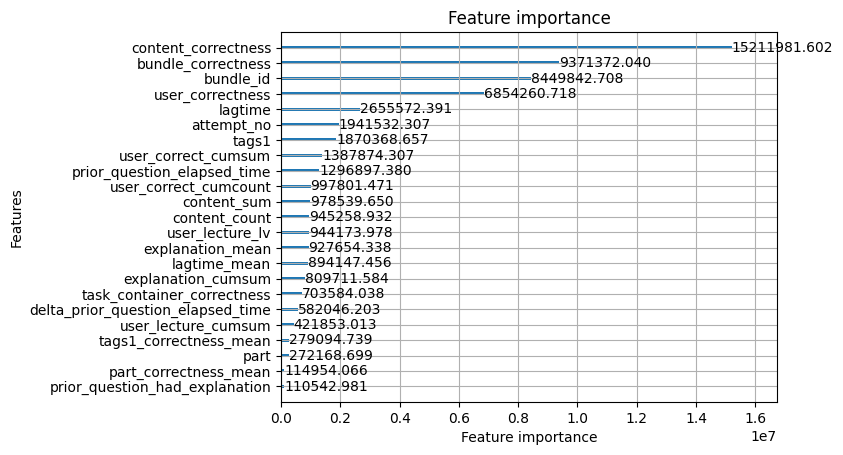

In [60]:

for i in range(0,num):

    tr_data = lgb.Dataset(trains[i][features], label=trains[i][target])
    va_data = lgb.Dataset(valids[i][features], label=valids[i][target])
    
    del trains
    del valids
    gc.collect()

    model = lgb.train(
        params, 
        tr_data,
        num_boost_round=500,
        #valid_sets=[(train_df[features],train_df[target]), (valid_df[features],valid_df[target])], 
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=features,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
    clfs.append(model)
    #print('auc:', roc_auc_score(valid_df[target], model.predict(valid_df[features])))
    #model.save_model(f'model.txt')
    lgb.plot_importance(model, importance_type='gain')
    plt.show()

    del tr_data
    del va_data
    gc.collect()

# Inference

In [61]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

task_container_sum_dict = task_container_agg['sum'].astype('int32').to_dict(defaultdict(int))
task_container_count_dict = task_container_agg['count'].astype('int32').to_dict(defaultdict(int))
task_container_std_dict = task_container_agg['var'].astype('float16').to_dict(defaultdict(int))

explanation_sum_dict = explanation_agg['sum'].astype('int16').to_dict(defaultdict(int))
explanation_count_dict = explanation_agg['count'].astype('int16').to_dict(defaultdict(int))

0

In [62]:
user_lecture_sum_dict = user_lecture_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_lecture_count_dict = user_lecture_agg['count'].astype('int16').to_dict(defaultdict(int))

lagtime_mean_dict = lagtime_agg['mean'].astype('int32').to_dict(defaultdict(int))

0

In [63]:
attempt_no_agg=attempt_no_agg[attempt_no_agg['sum'] >1]
attempt_no_sum_dict = attempt_no_agg['sum'].to_dict(defaultdict(int))

0

In [64]:
max_timestamp_u_dict=max_timestamp_u.set_index('user_id').to_dict()
user_prior_question_elapsed_time_dict=user_prior_question_elapsed_time.set_index('user_id').to_dict()

0

In [65]:
len(max_timestamp_u_dict['max_time_stamp'])

393656

In [66]:
def get_max_attempt(user_id,content_id):
    k = (user_id,content_id)

    if k in attempt_no_sum_dict.keys():
        attempt_no_sum_dict[k]+=1
        return attempt_no_sum_dict[k]

    attempt_no_sum_dict[k] = 1
    return attempt_no_sum_dict[k]

In [67]:
print(psutil.virtual_memory().percent)

16.3


# SAKT Part II

In [68]:
#HDKIM SAKT
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class FFN(nn.Module):
    def __init__(self, state_size=200):
        super(FFN, self).__init__()
        self.state_size = state_size

        self.lr1 = nn.Linear(state_size, state_size)
        self.relu = nn.ReLU()
        self.lr2 = nn.Linear(state_size, state_size)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.lr1(x)
        x = self.relu(x)
        x = self.lr2(x)
        return self.dropout(x)

def future_mask(seq_length):
    future_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype('bool')
    return torch.from_numpy(future_mask)

class SAKTModel(nn.Module):
    def __init__(self, n_skill, max_seq=MAX_SEQ, embed_dim=128): #HDKIM 100
        super(SAKTModel, self).__init__()
        self.n_skill = n_skill
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(2*n_skill+1, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq-1, embed_dim)
        self.e_embedding = nn.Embedding(n_skill+1, embed_dim)

        self.multi_att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, dropout=0.2)

        self.dropout = nn.Dropout(0.2)
        self.layer_normal = nn.LayerNorm(embed_dim) 

        self.ffn = FFN(embed_dim)
        self.pred = nn.Linear(embed_dim, 1)
    
    def forward(self, x, question_ids):
        device = x.device        
        x = self.embedding(x)
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)

        pos_x = self.pos_embedding(pos_id)
        x = x + pos_x

        e = self.e_embedding(question_ids)

        x = x.permute(1, 0, 2) # x: [bs, s_len, embed] => [s_len, bs, embed]
        e = e.permute(1, 0, 2)
        att_mask = future_mask(x.size(0)).to(device)
        att_output, att_weight = self.multi_att(e, x, x, attn_mask=att_mask)
        att_output = self.layer_normal(att_output + e)
        att_output = att_output.permute(1, 0, 2) # att_output: [s_len, bs, embed] => [bs, s_len, embed]

        x = self.ffn(att_output)
        x = self.layer_normal(x + att_output)
        x = self.pred(x)

        return x.squeeze(-1), att_weight
    
class TestDataset(Dataset):
    def __init__(self, samples, test_df, skills, max_seq=MAX_SEQ): #HDKIM 100
        super(TestDataset, self).__init__()
        self.samples = samples
        self.user_ids = [x for x in test_df["user_id"].unique()]
        self.test_df = test_df
        self.skills = skills
        self.n_skill = len(skills)
        self.max_seq = max_seq

    def __len__(self):
        return self.test_df.shape[0]

    def __getitem__(self, index):
        test_info = self.test_df.iloc[index]

        user_id = test_info["user_id"]
        target_id = test_info["content_id"]

        q = np.zeros(self.max_seq, dtype=int)
        qa = np.zeros(self.max_seq, dtype=int)

        if user_id in self.samples.index:
            q_, qa_ = self.samples[user_id]
            
            seq_len = len(q_)

            if seq_len >= self.max_seq:
                q = q_[-self.max_seq:]
                qa = qa_[-self.max_seq:]
            else:
                q[-seq_len:] = q_
                qa[-seq_len:] = qa_          
        
        x = np.zeros(self.max_seq-1, dtype=int)
        x = q[1:].copy()
        x += (qa[1:] == 1) * self.n_skill
        
        questions = np.append(q[2:], [target_id])
        
        return x, questions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAKT_model = SAKTModel(n_skill, embed_dim=128)

SAKT_model.load_state_dict(torch.load("/data/elastic-notebook/data/sakt-model/SAKT-HDKIM.pt", map_location='cpu'))

SAKT_model.to(device)
SAKT_model.eval()

import pickle
group = pickle.load(open("group.pkl", "rb"))

print(psutil.virtual_memory().percent)

#HDKIMHDKIM

16.3
